In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [49]:
"""
Created on March 25, 2023

@author: Josh Goodwill
"""

import numpy as np
from scipy.optimize import curve_fit

'''
def gen_fit(x, y):
Generates fit of linear and sqrt portion of IV arrays. Refer to
data_processing to idenify filtering of IV arrays. scipy.optimize.curve_fit
used to fit non-linear least squares to fit


input:
V_arr (array); Voltage array
I_arr (array); Current array
proc* (boolean); Whether to process the arrays for better fitting

output:
V_fit (np.array); linear space between min and max voltages from V_arr
model(t, *popt) (np.array); fitted model of I_arr using Voltage range and 
                            pointer to popt
popt(array); optimal values for parameters
  V_f  (float) = popt[0]; floating potential
  m1   (float) = popt[1]; slope of linear fit
  b    (float) = popt[2]; y-intercept of linear fit
  a    (float) = popt[3]; multiplication factor of exponential fit
  ne   (float) = popt[4]; electron density [cm^{-3}]
  etemp(float) = popt[5]; electron temperature [K]
  VP   (float) = popt[6]; plasma potential [V]
  
Intial guesses/[bounds]:
    V_f   = 0.3   ; [0: 0.5]
    m1    = 100   ; [-1000:1000]
    b     = 80    ; [-100:100]
    a     = 5     ; [0:100]
    ne    = 8*10^8; [0, np.inf]
    etemp = 1000  ; [0, 10000]
    VP    = 0.9   ; [0.5, 1.5]

pcov(2D np.array); covariance of popt array
'''

def gen_fit(V_arr, I_arr, proc = False):
    V_proc = []
    I_proc = []
    if proc == True:
        V_proc, I_proc = data_processing(V_arr, I_arr)
    else:
        V_proc, I_proc = V_arr, I_arr
    guess = [0.3, 0.9, 100, 80,  2,  8*(10**10), 1000]    #intial guess
    b = ((0, 0.5, -1000,-100, 0, 0, 0),(0.5, 1.5, 1000,100, 100, np.inf,10000)) #bounds

    # guess = [0.5, 100, 80, 1000, 0.5, 1]    #intial guess
    # b = ((0, -1000, -100, 0, 0, 0.5),(1, 1000, 100, 10000, 100, 3)) #bounds

    popt, pcov = curve_fit(model, V_proc, I_proc, guess, bounds = b)
    # popt, pcov = curve_fit(model, V_proc, I_proc)
    V_fit = np.linspace(min(V_proc),max(V_proc), num = 300) #Voltage array processed for fit
    return V_fit, model(V_fit,*popt), popt, pcov

'''
def model(V_proc, VP, m1, b, ne, etemp, V0):
Model to fit ion, *transition*, electron saturation regions

input:
V_proc (np.array); processed V_arr for fitting
Vf (float); floating potential
m1 (float); slope of linear fit
b  (float); y-intercept of linear fit
ne (float); electron density [cm^{-2}]
etemp(float); electron temperature [K]
VP (float); plasma potential [V]
'''

def model(V_proc, Vf, VP, m1, b, ne, etemp):
    I_fit = np.zeros(len(V_proc))
    #Linear fit for ion saturation
    I_fit[V_proc <= Vf] = lin_fit(V_proc[V_proc <= Vf], m1, b)
    I1_cont =  -(exp_fit(Vf, ne,  etemp, Vf) + lin_fit(Vf, m1, b))
    #Exp fit for transition region
    I_fit[(V_proc > Vf) & (V_proc <= VP)] = exp_fit(V_proc[(V_proc > Vf) & (V_proc <= VP)], ne, etemp,  Vf) + I1_cont
    I2_cont = -(exp_fit(VP, ne, etemp,  Vf) + I1_cont)
    #Sqrt fit for electron saturation
    I_fit[V_proc > VP] = sqrt_fit(V_proc[V_proc > VP], ne, etemp ,VP) + I2_cont
    return I_fit

def lin_fit(x, m, y_int): #linear--full model square root
    return m * x + y_int

def exp_fit(x, ne, etemp, Vf): #exponential fit
    q_e = 1.602 * 10**-19 #electron charge [C]
    K_b = 1.381 * 10**-23 #boltzman constant [m^2*kg/(s^2*K)]   
    k = q_e / (K_b * etemp) 
    K_b = 1.381 * 10**-23 #boltzman constant [m^2*kg/(s^2*K)]   
    m_e = 9.109 * 10**-31 #electron mass [kg]              
    R = (3./16.) * 0.0254 #radius of probe [cm?]
    L = (3.25) * 0.0254 #length of probe [cm?]
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #top and length area of cylinder [cm^2]

    k = q_e / (K_b * etemp)
    I0 = ne * q_e * np.sqrt(K_b * etemp / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.exp(k * (x - Vf))

'''
def sqrt_fit(x, ne, etemp, V0)
Uses Eq. 1.4 and 1.5 of https://digitalcommons.usu.edu/etd/274

input:
x (np.array); V_proc [V]
ne (float); electron density [cm?]
etemp(float); electron temperature [K]
VP (float); negative plasma potential [V]

output:
I (float); current fit [nA]
'''
def sqrt_fit(x, ne, etemp, VP):# square root
    q_e = 1.602 * 10**-19 #electron charge [C]
    K_b = 1.381 * 10**-23 #boltzman constant [m^2*kg/(s^2*K)]   
    m_e = 9.109 * 10**-31 #electron mass [kg]              
    R = (3./16.) * 0.0254 #radius of probe [cm]
    L = (3.25) * 0.0254 #length of probe [cm]
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #top and length area of cylinder [cm^2]

    k = q_e / (K_b * etemp)
    I0 = ne * q_e * np.sqrt(K_b * etemp / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.sqrt(1. + k*(x - VP))

'''
def data_processing(V, I)
Processes Voltage and Current arrays to reduce points for fitting algorithm.
Removes Voltage below -3 V and above first max of Current array

input:
V (np.array); Normal Voltage array
I (np.array); Normal Current array

output:
V_proc (np.array); processed Voltage array
I_proc (np.array); processed Current array
'''

def data_processing(V, I):
    Imax = np.argmax(I) #find index of maximum Current
    if (Imax.size != 1):
        Vmin_Imax = np.argmin(V[Imax]) #find lowest voltage value with max current
    else:
        Vmin_Imax = Imax
    V_rem = (V > -3) & (V < V[Vmin_Imax]) #array of voltages > -3V and < Vmin_Imax
    V_proc = V[V_rem]
    I_proc = I[V_rem]
    return V_proc, I_proc

In [50]:
Varr = np.linspace(-6, 6, 500)
Iarr = model(Varr, 0.4, 0.4, 20, 10, 6e10, 850)

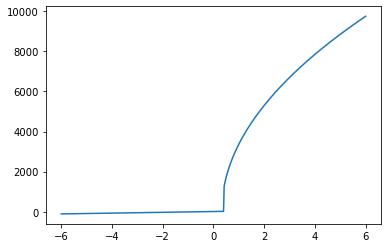

In [51]:
plt.plot(Varr, Iarr)
# plt.ylim(-100, 3000)
# plt.xlim(0,3)